In [ ]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# Load the dataset
# Replace 'parkinsons.csv' with the path to your dataset file
data = pd.read_csv("parkinsons.data")

In [ ]:
# Preprocessing
# Drop 'name' column (identifier) and separate features and target
X = data.drop(['name', 'status'], axis=1)
y = data['status']

# Check class distribution to assess imbalance
print("Class Distribution (0=Healthy, 1=PD):")
print(y.value_counts())

# Normalize features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training (80%) and testing (20%) sets with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)



Class Distribution (0=Healthy, 1=PD):
status
1    147
0     48
Name: count, dtype: int64


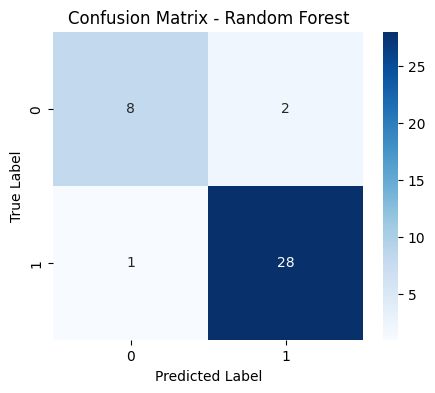


Random Forest Results:
Accuracy: 0.9231
F1-Score: 0.9492
ROC-AUC: 0.9759
Precision: 0.9333
Recall: 0.9655


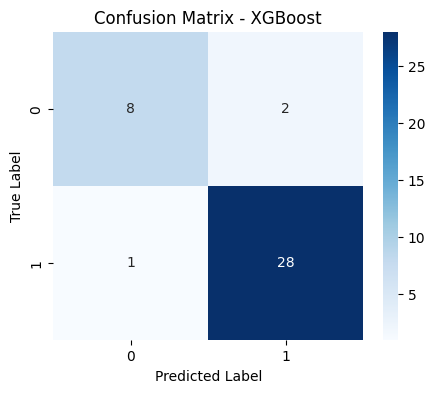


XGBoost Results:
Accuracy: 0.9231
F1-Score: 0.9492
ROC-AUC: 0.9793
Precision: 0.9333
Recall: 0.9655


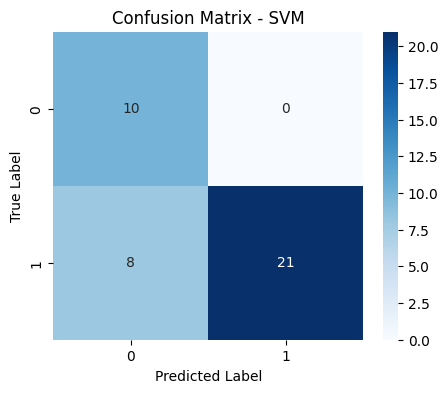


SVM Results:
Accuracy: 0.7949
F1-Score: 0.8400
ROC-AUC: 0.9379
Precision: 1.0000
Recall: 0.7241


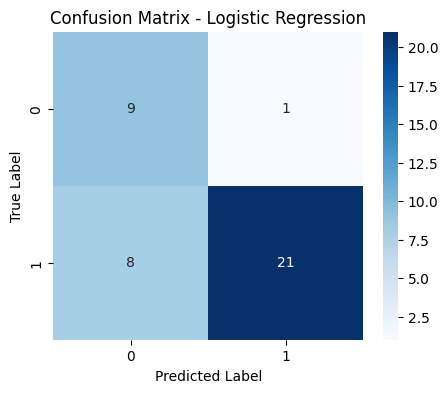


Logistic Regression Results:
Accuracy: 0.7692
F1-Score: 0.8235
ROC-AUC: 0.9276
Precision: 0.9545
Recall: 0.7241


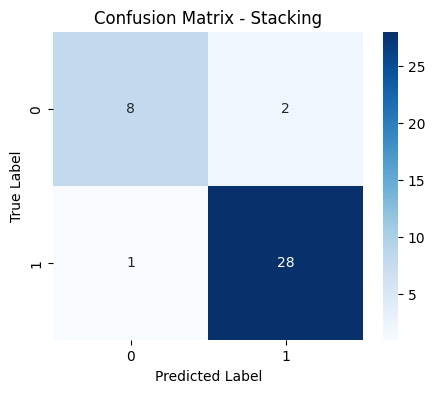


Stacking Results:
Accuracy: 0.9231
F1-Score: 0.9492
ROC-AUC: 0.9724
Precision: 0.9333
Recall: 0.9655


In [ ]:
# Define ensemble models
# Random Forest with balanced class weights to handle imbalance
rf = RandomForestClassifier(
    n_estimators=100, max_depth=10, random_state=42, class_weight='balanced'
)

# XGBoost with scale_pos_weight to handle class imbalance
xgb = XGBClassifier(
    n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42, scale_pos_weight=1
)

# SVM as a base model for stacking
svm = SVC(probability=True, random_state=42, class_weight='balanced')

# Logicstic Regression
lgs = LogisticRegression(class_weight='balanced', random_state=42)


# Stacking classifier combining Random Forest, XGBoost, and SVM
estimators = [
    ('rf', rf),
    ('xgb', xgb),
    ('svm', svm),
    ('lgs', lgs)
]
stacking = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression(), cv=5
)

# Dictionary to store models
models = {
    'Random Forest': rf,
    'XGBoost': xgb,
    'SVM': svm,
    'Logistic Regression': lgs,
    'Stacking': stacking
}

# Dictionary to store results
results = {}

# Train and evaluate each model
for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    # Store results
    results[name] = {
        'Accuracy': accuracy,
        'F1-Score': f1,
        'ROC-AUC': roc_auc,
        'Precision': precision,
        'Recall': recall
    }

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Print metrics
    print(f"\n{name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")



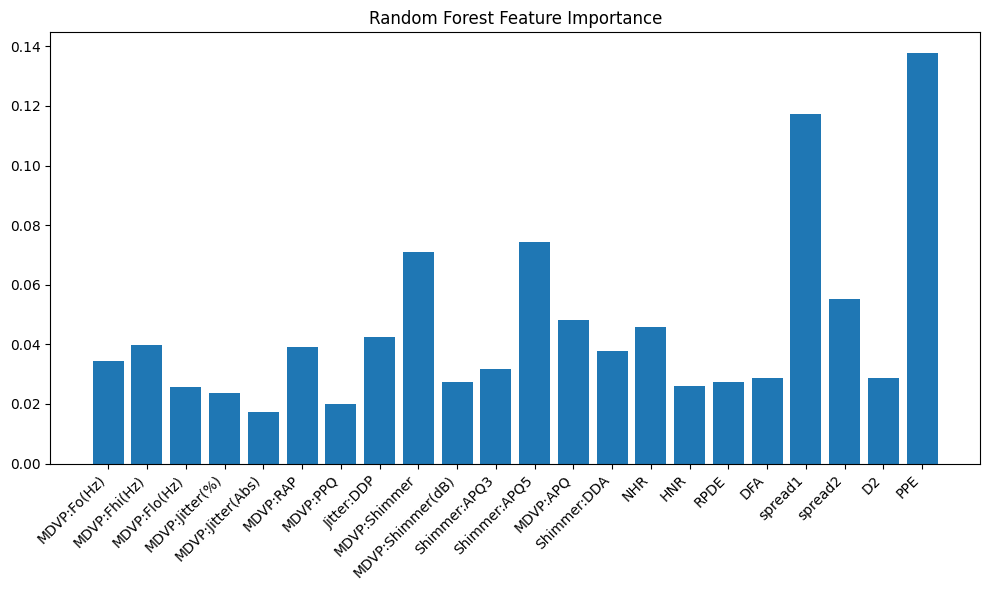

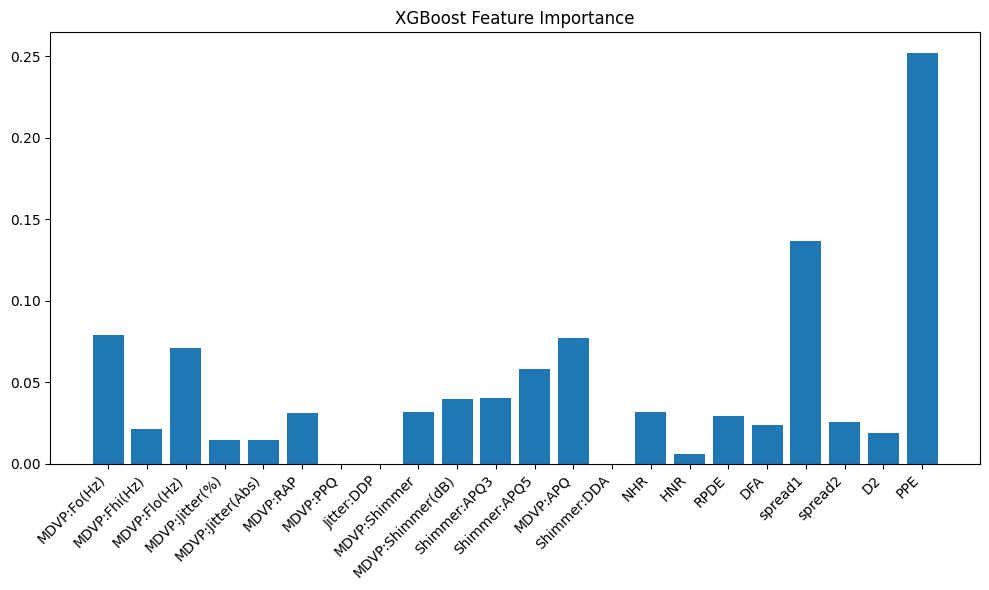


Model Comparison:
                     Accuracy  F1-Score   ROC-AUC  Precision    Recall
Random Forest        0.923077  0.949153  0.975862   0.933333  0.965517
XGBoost              0.923077  0.949153  0.979310   0.933333  0.965517
SVM                  0.794872  0.840000  0.937931   1.000000  0.724138
Logistic Regression  0.769231  0.823529  0.927586   0.954545  0.724138
Stacking             0.923077  0.949153  0.972414   0.933333  0.965517

Random Forest 5-Fold CV F1-Scores: [0.83870968 0.89230769 0.92857143 0.84375    0.85294118]
Mean CV F1-Score: 0.8713 ± 0.0343

XGBoost 5-Fold CV F1-Scores: [0.89230769 0.90909091 0.98305085 0.82539683 0.87878788]
Mean CV F1-Score: 0.8977 ± 0.0510

SVM 5-Fold CV F1-Scores: [0.80769231 0.84745763 0.84615385 0.78688525 0.80645161]
Mean CV F1-Score: 0.8189 ± 0.0239

Logistic Regression 5-Fold CV F1-Scores: [0.88888889 0.83870968 0.86792453 0.70175439 0.79365079]
Mean CV F1-Score: 0.8182 ± 0.0664

Stacking 5-Fold CV F1-Scores: [0.875      0.90909091 0.9

In [ ]:
# Feature importance for Random Forest, SVM and XGBoost
feature_names = X.columns

# Random Forest feature importance
plt.figure(figsize=(10, 6))
plt.bar(feature_names, rf.feature_importances_)
plt.xticks(rotation=45, ha='right')
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.show()

# XGBoost feature importance
plt.figure(figsize=(10, 6))
plt.bar(feature_names, xgb.feature_importances_)
plt.xticks(rotation=45, ha='right')
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.show()


# Compare model performance
results_df = pd.DataFrame(results).T
print("\nModel Comparison:")
print(results_df)

# Perform 5-fold cross-validation for robustness
for name, model in models.items():
    cv_scores = cross_val_score(model, X_scaled, y, cv=5, scoring='f1')
    print(f"\n{name} 5-Fold CV F1-Scores: {cv_scores}")
    print(f"Mean CV F1-Score: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

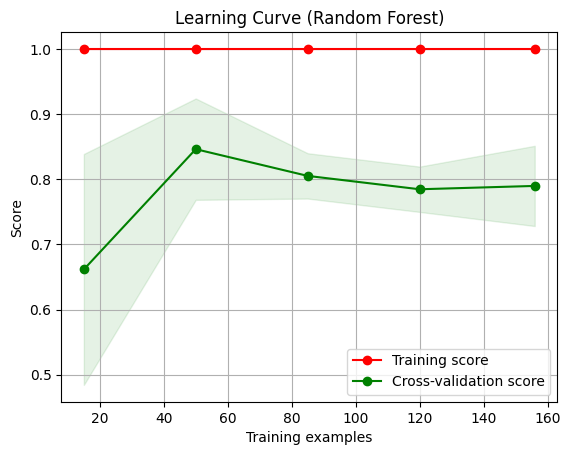

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
4 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/xgboost/core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py", line 1559, in fit
    raise ValueError(
ValueError: Invalid classes inferred from unique values of `y`.  Expec

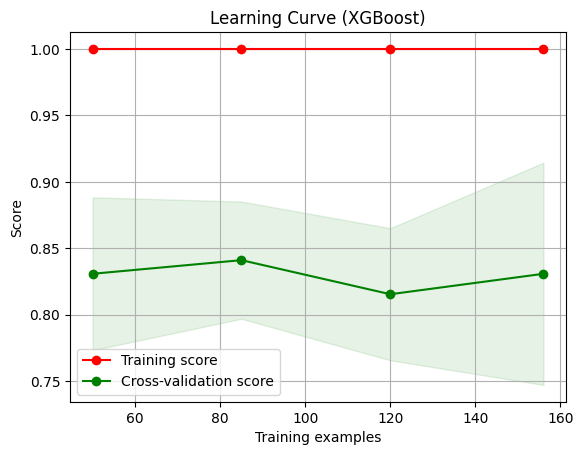

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
4 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py", line 207, in fit
    y = self._validate_targets(y)
        

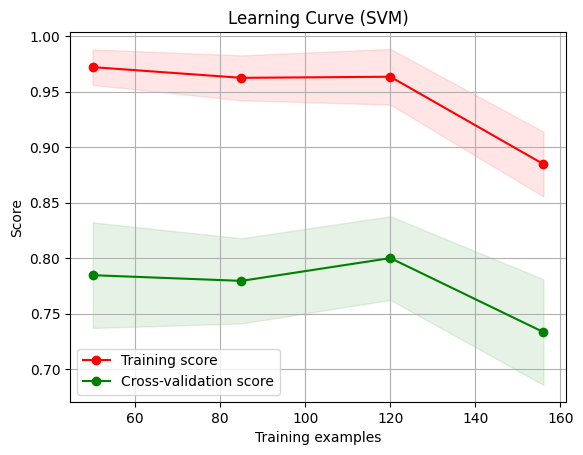

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
4 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py", line 1301, in fit
    raise ValueError(
ValueE

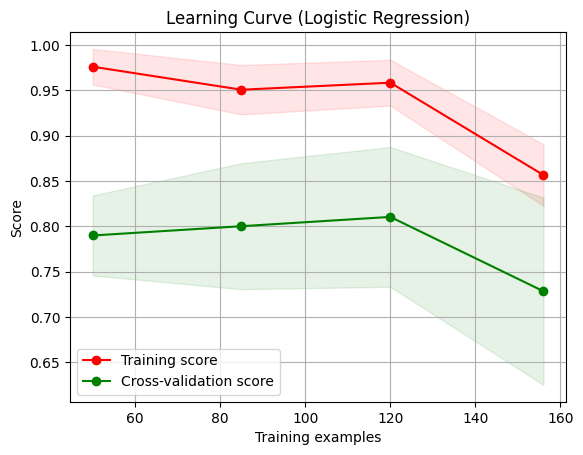

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
4 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_stacking.py", line 717, in fit
    return super().fit(X, y_encoded, **fit_params)
           ^

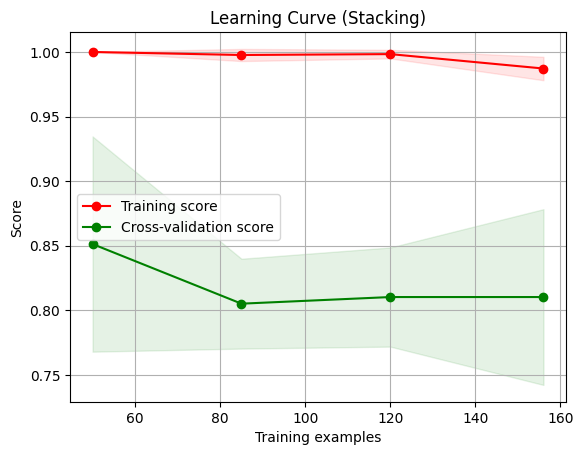

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the training and test learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` is used. In all other cases, :class:`KFold`
        is used.
        Refer :ref:`User Guide <cross_validation>`.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is considered to
        be a fraction of the maximum number of samples (hence, it must be in
        (0, 1]). Otherwise, it is interpreted as absolute numbers of training
        examples. Note that for classification the number of samples usually
        also depends on the class proportions.
    """
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Example usage with one of your models:
plot_learning_curve(rf, "Learning Curve (Random Forest)", X_scaled, y, cv=5)
plt.show()

plot_learning_curve(xgb, "Learning Curve (XGBoost)", X_scaled, y, cv=5)
plt.show()

plot_learning_curve(svm, "Learning Curve (SVM)", X_scaled, y, cv=5)
plt.show()

plot_learning_curve(lgs, "Learning Curve (Logistic Regression)", X_scaled, y, cv=5)
plt.show()

plot_learning_curve(stacking, "Learning Curve (Stacking)", X_scaled, y, cv=5)
plt.show()

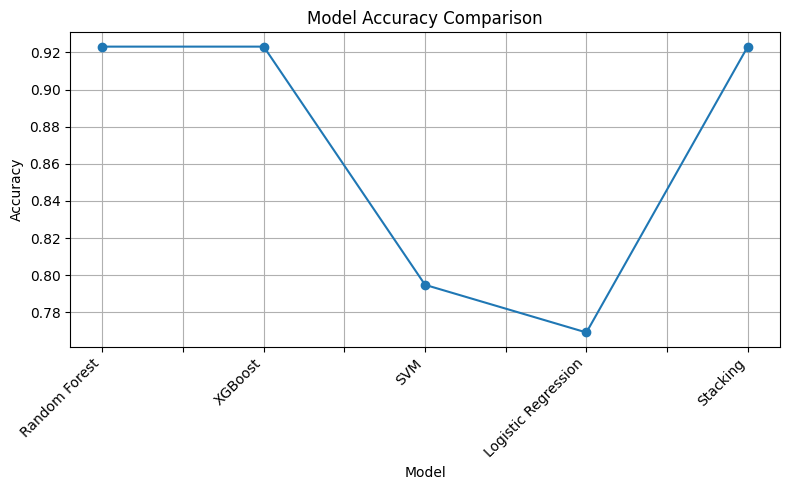

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'results_df' is the DataFrame containing your model results
# results_df = pd.DataFrame(results).T # Make sure this DataFrame exists

plt.figure(figsize=(8, 5)) # Optional: adjust the figure size
results_df['Accuracy'].plot(kind='line', marker='o')
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.grid(True)
plt.show()

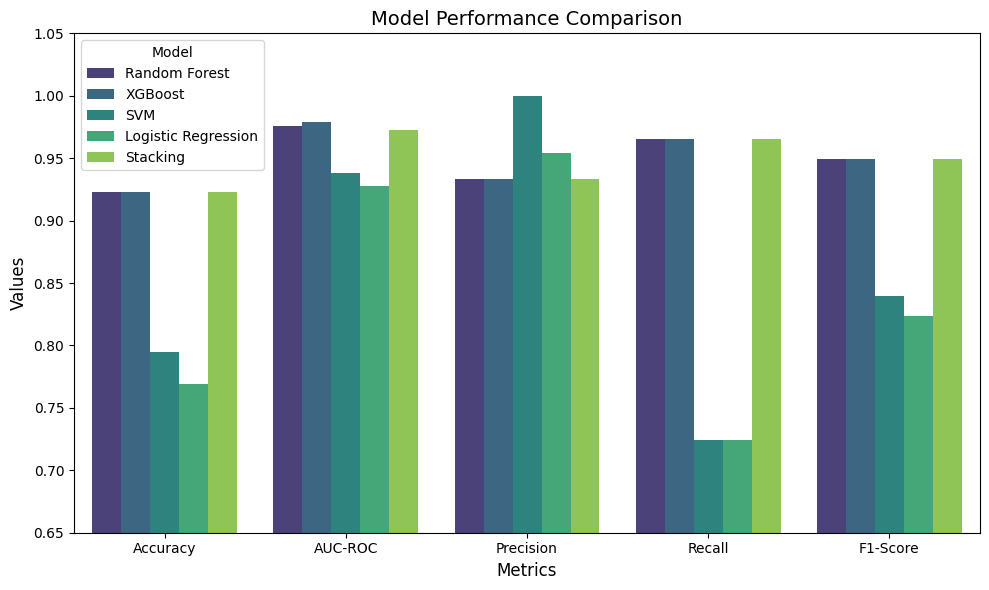

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'results' dictionary contains your model performance data like this:
# results = {
#     'Random Forest': {'Accuracy': 0.9, 'F1-Score': 0.85, ...},
#     'XGBoost': {'Accuracy': 0.92, 'F1-Score': 0.88, ...},
#     'SVM': {'Accuracy': 0.88, 'F1-Score': 0.82, ...},
#     'Logistic Regression': {'Accuracy': 0.89, 'F1-Score': 0.84, ...},
#     'Stacking': {'Accuracy': 0.93, 'F1-Score': 0.91, ...}
# }

# Create a DataFrame from the results dictionary
results_df = pd.DataFrame(results).T

# Reset index to make 'Model' a column for melting
metrics_df = results_df.reset_index().rename(columns={'index': 'Model'})

# Metrics to plot (renamed 'ROC-AUC' to 'AUC-ROC')
# Ensure the column name in results_df matches the metric name.
# If your dictionary uses 'ROC-AUC', change it to 'AUC-ROC' here or in the dictionary.
metrics_to_plot = ['Accuracy', 'AUC-ROC', 'Precision', 'Recall', 'F1-Score']

# Rename 'ROC-AUC' column in the DataFrame to 'AUC-ROC' if it exists
if 'ROC-AUC' in metrics_df.columns:
    metrics_df = metrics_df.rename(columns={'ROC-AUC': 'AUC-ROC'})


# Melt the metrics dataframe for plotting
melted_df = metrics_df.melt(
    id_vars=["Model"], value_vars=metrics_to_plot,
    var_name="Metric", value_name="Value"
)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(
    x="Metric",
    y="Value",
    hue="Model",
    data=melted_df,
    palette="viridis",
    dodge=True
)
plt.title("Model Performance Comparison", fontsize=14)
plt.xlabel("Metrics", fontsize=12)
plt.ylabel("Values", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title="Model", fontsize=10)
plt.ylim(0.65, None) # Set y-axis limit for better visualization
plt.tight_layout()

plt.show()